<a href="https://colab.research.google.com/github/w114050009-maker/MathAnalysisDataSci/blob/main/DataSciMath_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


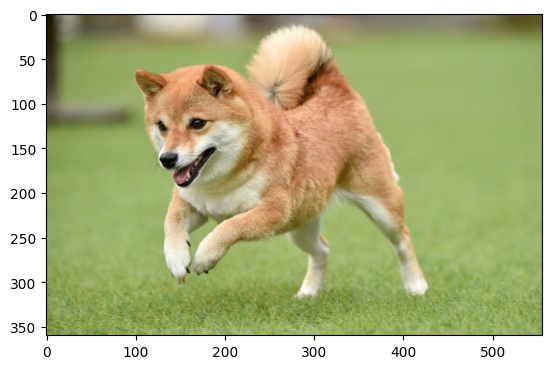

In [27]:
img = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/mathAnalysis/picture/shiba.jpg")

plt.imshow(img)
#plt.axis('off')  # 隱藏座標軸
#plt.show()

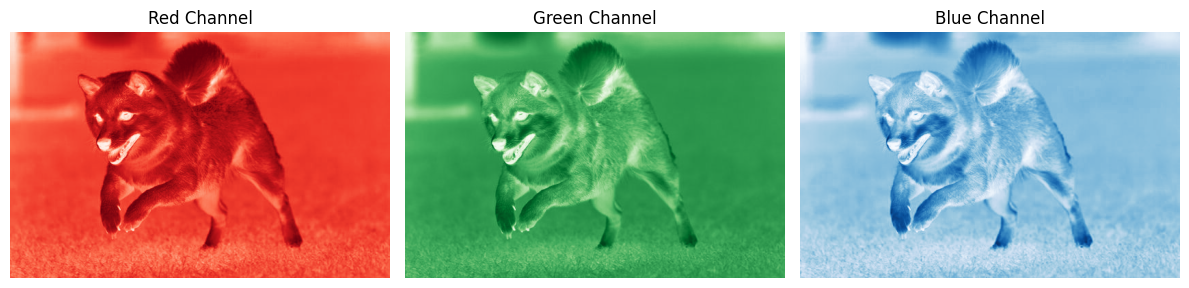

image dim = (360, 556)


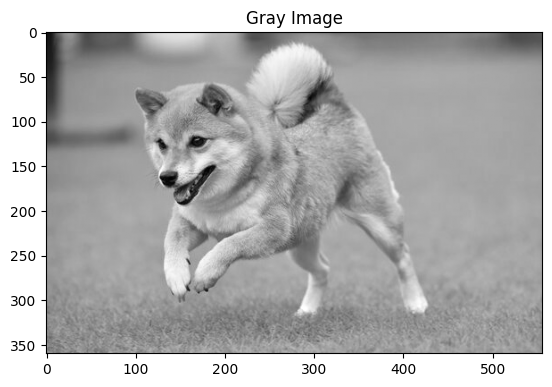

In [28]:
arr_shiba = np.array(img) #transform from img to array

img_R = arr_shiba[:,:,0]
img_G = arr_shiba[:,:,1]
img_B = arr_shiba[:,:,2]

# 建立 1x3 的 subplot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 顯示 R channel（紅色）
axes[0].imshow(img_R, cmap='Reds')
axes[0].set_title('Red Channel')
axes[0].axis('off')

# 顯示 G channel（綠色）
axes[1].imshow(img_G, cmap='Greens')
axes[1].set_title('Green Channel')
axes[1].axis('off')

# 顯示 B channel（藍色）
axes[2].imshow(img_B, cmap='Blues')
axes[2].set_title('Blue Channel')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Use luminosity method to get gray image
img_gray = np.dot(arr_shiba[..., :3], [0.299, 0.587, 0.114])
plt.title("Gray Image")
plt.imshow(img_gray, cmap='gray')
#plt.axis('off')  # 隱藏座標軸
#plt.show(
print("image dim =", img_gray.shape)

In [29]:
# 2-norm
def norm2(a, ak):
  return np.linalg.norm(a - ak, 2)

In [30]:
# MSE: Mean Square Error
def mse(image, image_svd):
  return np.mean((image.astype(np.float64) - image_svd.astype(np.float64))\
          ** 2) #Covert to float

In [31]:
def gen_svd_pic(image, k, rgb):
  u, sigma, v = np.linalg.svd(image, full_matrices=False)

  # Method 1
  p = min(image.shape[0], image.shape[1]) #p=min(row_size ,colume_size)
  #print("image size =", image.shape)
  #print("p= ", p)

  if k > p:
    k = p

  # Method 2
  #k = min(len(sigma)-1, k)
  #print("k=",k)

  # k = 0 ~ k-1
  #Ak = U * A * V_T
  Ak = np.dot(u[:,:k], np.dot(np.diag(sigma[:k]), v[:k,:]))

  norm = norm2(image, Ak)

  m = mse(image, Ak)

  # 0 ~ 255
  Ak[Ak < 0] = 0
  Ak[Ak > 255] = 255

  Ak = np.rint(Ak).astype('uint8') #round off Ak

  return Ak, sigma, norm, sigma[k], m

In [32]:
def psnr(image, image_svd):
  m = mse(image, image_svd)
  if m < 1e-10:
    return 100
  else:
    return 10 * math.log10(255.0**2 / m) #2**8-1

In [33]:
def compression_rate(img, img_svd, k):
  # compress ratio = (m * n) / k * (m + n + 1)
  size_img = img.shape[0] * img.shape[1]
  size_img_svd = (img_svd.shape[0] + img_svd.shape[1] + 1) * k

  return (size_img / size_img_svd)

In [34]:
def showLinear(table, resize):
  fig, axs = plt.subplots(2, 2, figsize=(12, 10))

  # Plot 1: Sigma k+1
  axs[0, 0].plot(table[:, 0], table[:, 2], 's-', color='green', label="Sigma k+1")
  axs[0, 0].set_xlabel("k", fontsize=20, labelpad=10)
  #axs[0, 0].set_ylabel("Sigma k+1", fontsize=20, labelpad=10)
  axs[0, 0].legend(loc="best", fontsize=15)

  # Plot 2: MSE / resize
  axs[0, 1].plot(table[:, 0], table[:, 3], 's-', color='blue', label="MSE")
  axs[0, 1].set_xlabel("k", fontsize=20, labelpad=10)
  axs[0, 1].set_ylabel("MSE", fontsize=20, labelpad=10)
  axs[0, 1].legend(loc="best", fontsize=15)

  # Plot 3: Compression Ratio
  axs[1, 0].plot(table[:, 0], table[:, 4], 's-', color='orange', label="CR")
  axs[1, 0].set_xlabel("k", fontsize=20, labelpad=10)
  axs[1, 0].set_ylabel("CR", fontsize=20, labelpad=10)
  axs[1, 0].legend(loc="best", fontsize=15)

  # Plot 4: PSNR
  axs[1, 1].plot(table[:, 0], table[:, 5], 's-', color='red', label="PSNR")
  axs[1, 1].set_xlabel("k", fontsize=20, labelpad=10)
  axs[1, 1].set_ylabel("PSNR", fontsize=20, labelpad=10)
  axs[1, 1].legend(loc="best", fontsize=15)

  plt.tight_layout()
  plt.show()

**Gray**

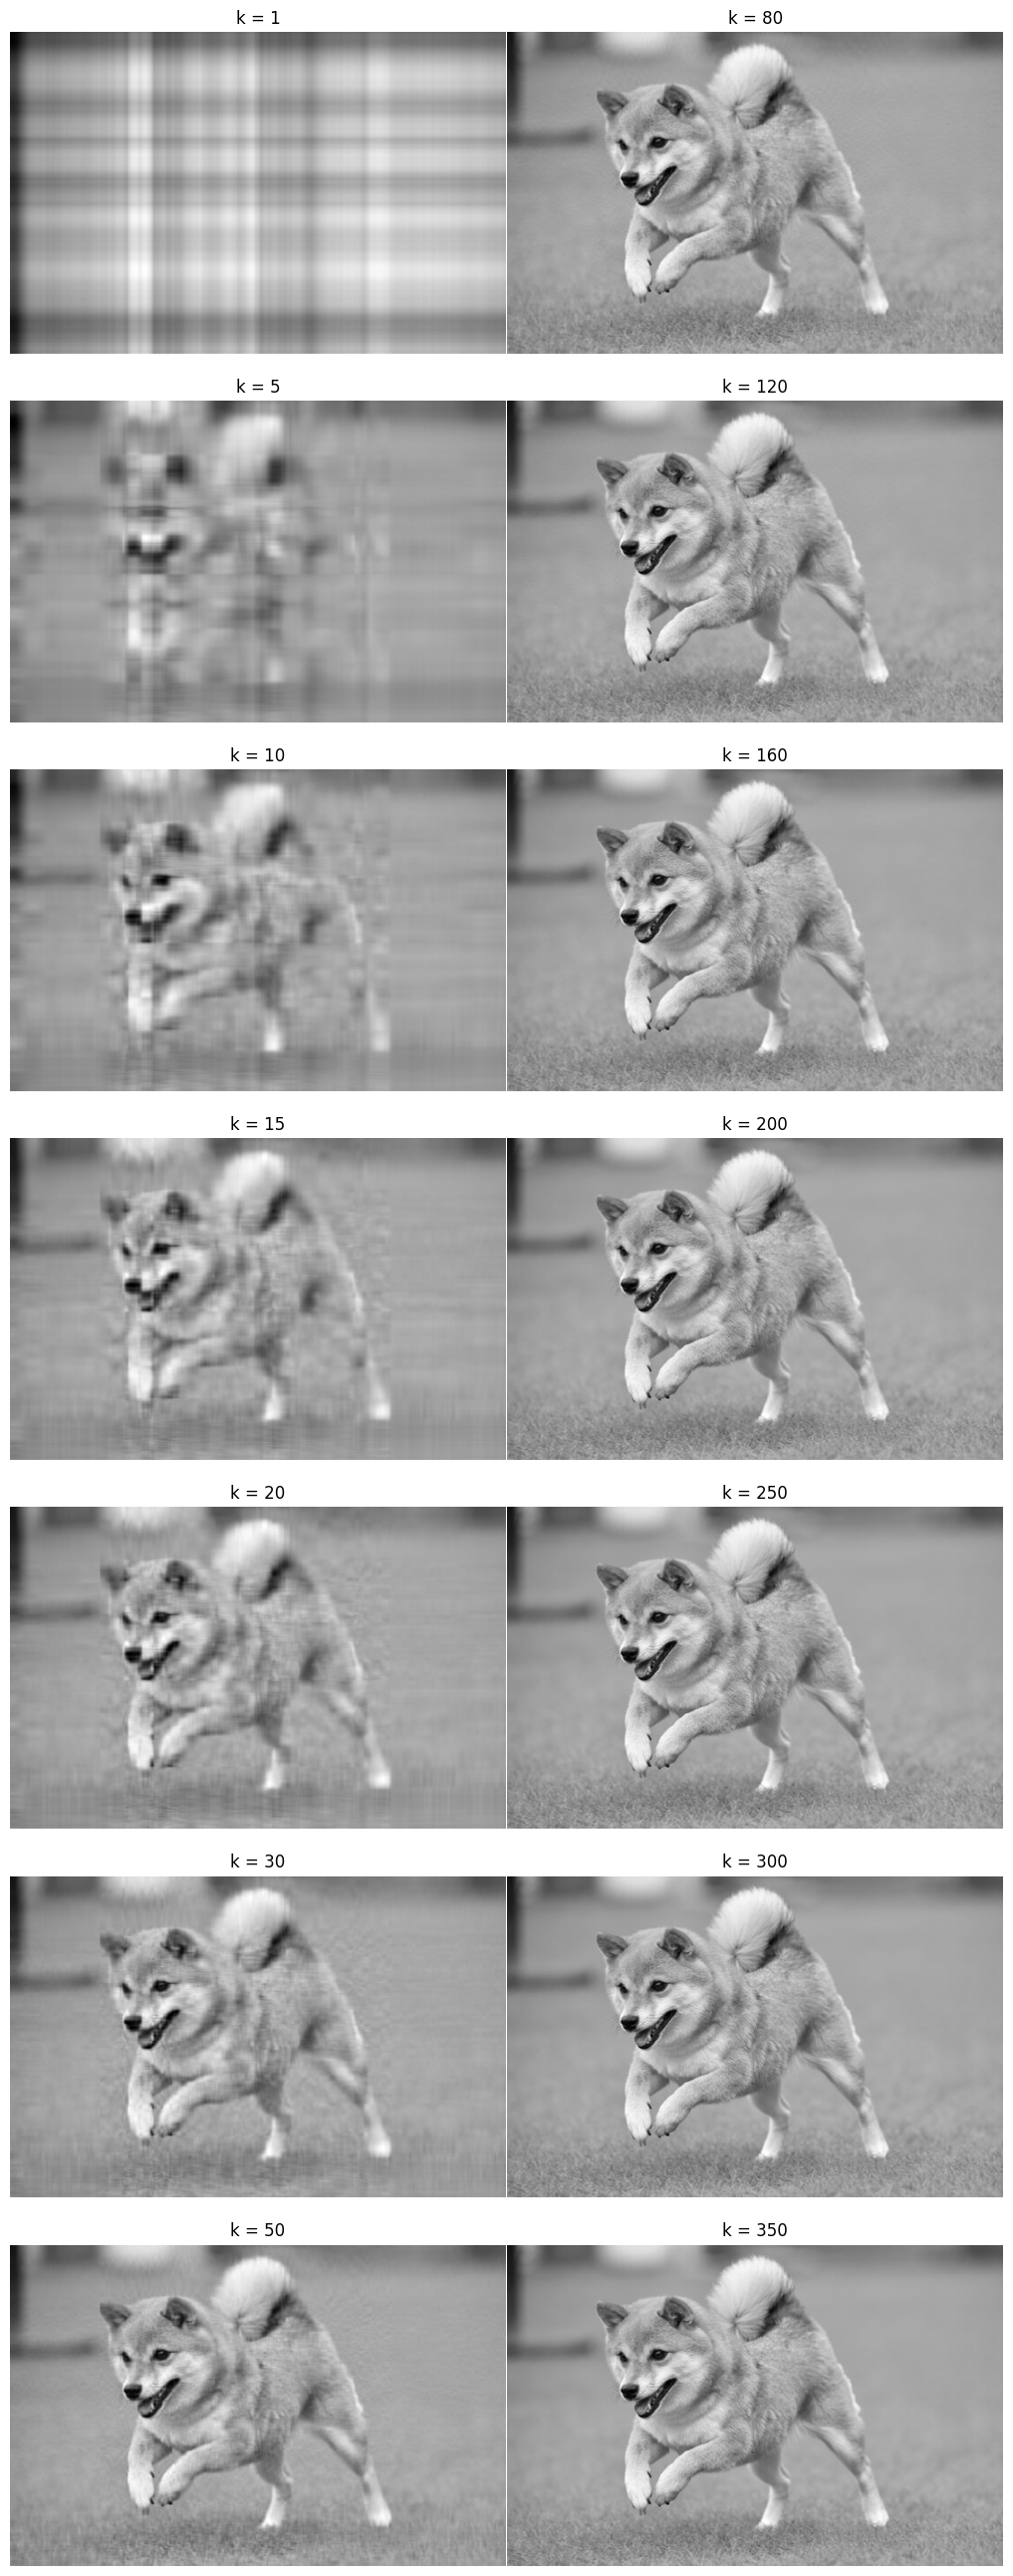

In [35]:
list_k = [1, 5, 10, 15, 20, 30, 50, 80, 120, 160, 200, 250, 300, 350, 400]

list_feature = ["K", "2-norm", "sigma k+1", "CR", "MSE", "PSNR"]

# Use the grayscale image for SVD
img_gen = []
data = []

# Limit the range of k to the smaller dimension of the image (360)
max_k = min(img_gray.shape)
valid_list_k = [k for k in list_k if k <= max_k]


fig, axes = plt.subplots(7, 2, figsize=(10, 26))

for i in valid_list_k:
  img_svd, sigma, norm, sigma_k1, m = gen_svd_pic(img_gray, i, "gray")
  img_gen.append(img_svd)
  # Handle the case where sigma_kp1 is None
  data.append([i, norm, sigma_k1, compression_rate(img_gray, img_svd, i),
        m, psnr(img_gray, img_svd)])


for i, ax in enumerate(axes.flat):
  if i < len(img_gen): # Ensure we don't go out of bounds of img_gen
    row = i % 7       # 先填第一列，再第二列
    col = i // 7      # 每列從左到右
    ax = axes[row, col]
    ax.imshow(img_gen[i], cmap='gray') # Add cmap='gray' here
    ax.set_title(f'k = {valid_list_k[i]}')
    ax.axis('off')  # 隱藏座標軸
    #plt.show()
  else:
    fig.delaxes(ax) # Remove unused subplots
plt.tight_layout(pad=0.1)
plt.show()

In [36]:
table = pd.DataFrame(data, columns=list_feature)
table

K       2-norm    sigma k+1          CR         MSE       PSNR
0     1  5248.641845  5248.641845  218.276990  610.818733  20.270729
1     5  2644.896875  2644.896875   43.655398  235.812877  24.403622
2    10  1501.351642  1501.351642   21.827699  126.380439  27.110482
3    15  1092.967108  1092.967108   14.551799   80.275732  29.081322
4    20   803.501074   803.501074   10.913850   56.450927  30.607098
5    30   527.011093   527.011093    7.275900   34.387460  32.757962
6    50   319.576871   319.576871    4.365540   17.317560  35.726762
7    80   198.404199   198.404199    2.728462    7.577533  39.289082
8   120   117.137507   117.137507    1.818975    2.714863  43.660521
9   160    71.768429    71.768429    1.364231    0.898904  48.222684
10  200    41.474395    41.474395    1.091385    0.249057  53.130139
11  250    16.772251    16.772251    0.873108    0.034278  60.121413
12  300     6.182325     6.182325    0.727590    0.005444  62.210069
13  350     2.803471     2.803471    0.623649    0.000292  62.421264

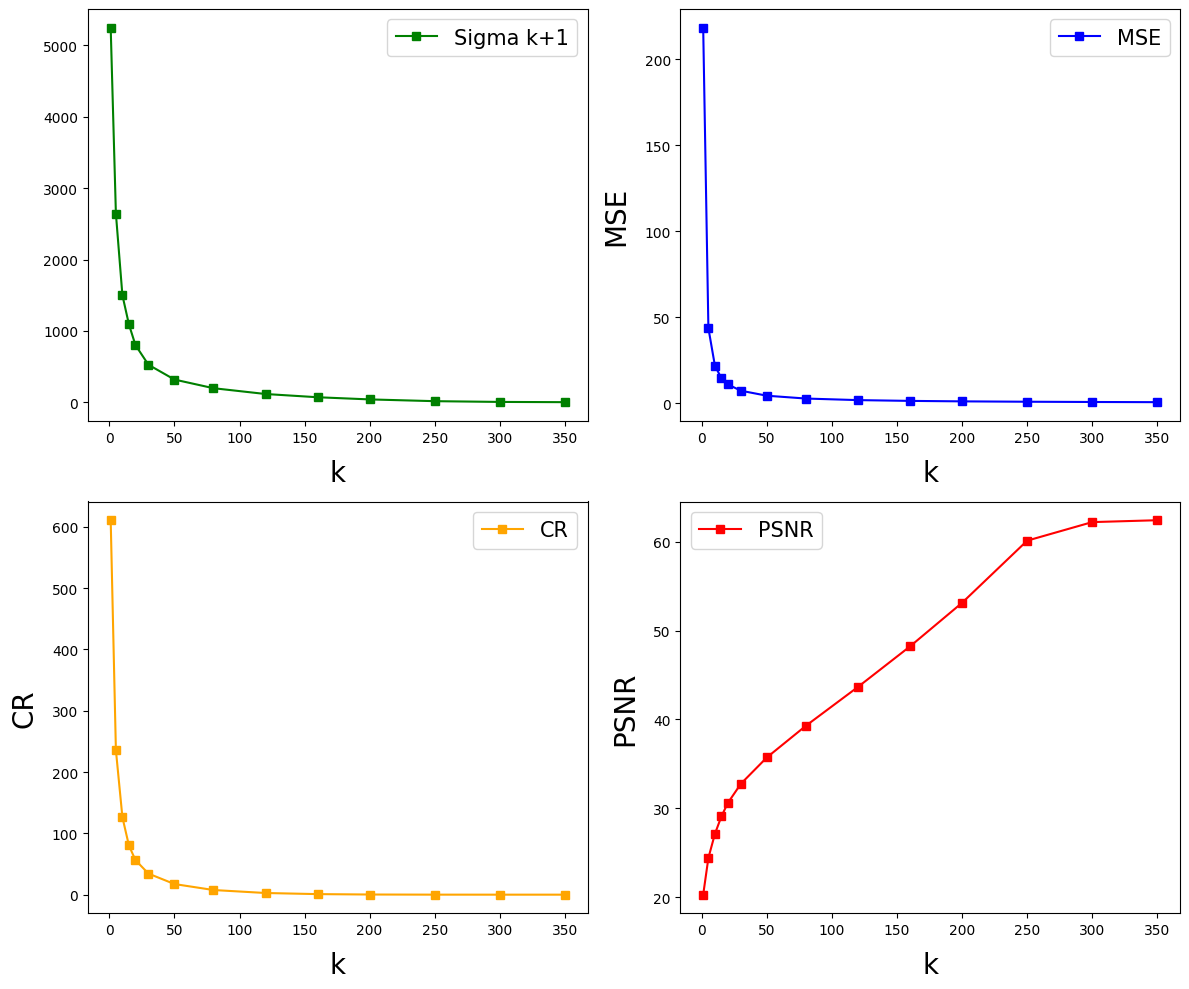

In [37]:
showLinear(table.values, 50)

**Color(RGB) - 3 Layers**

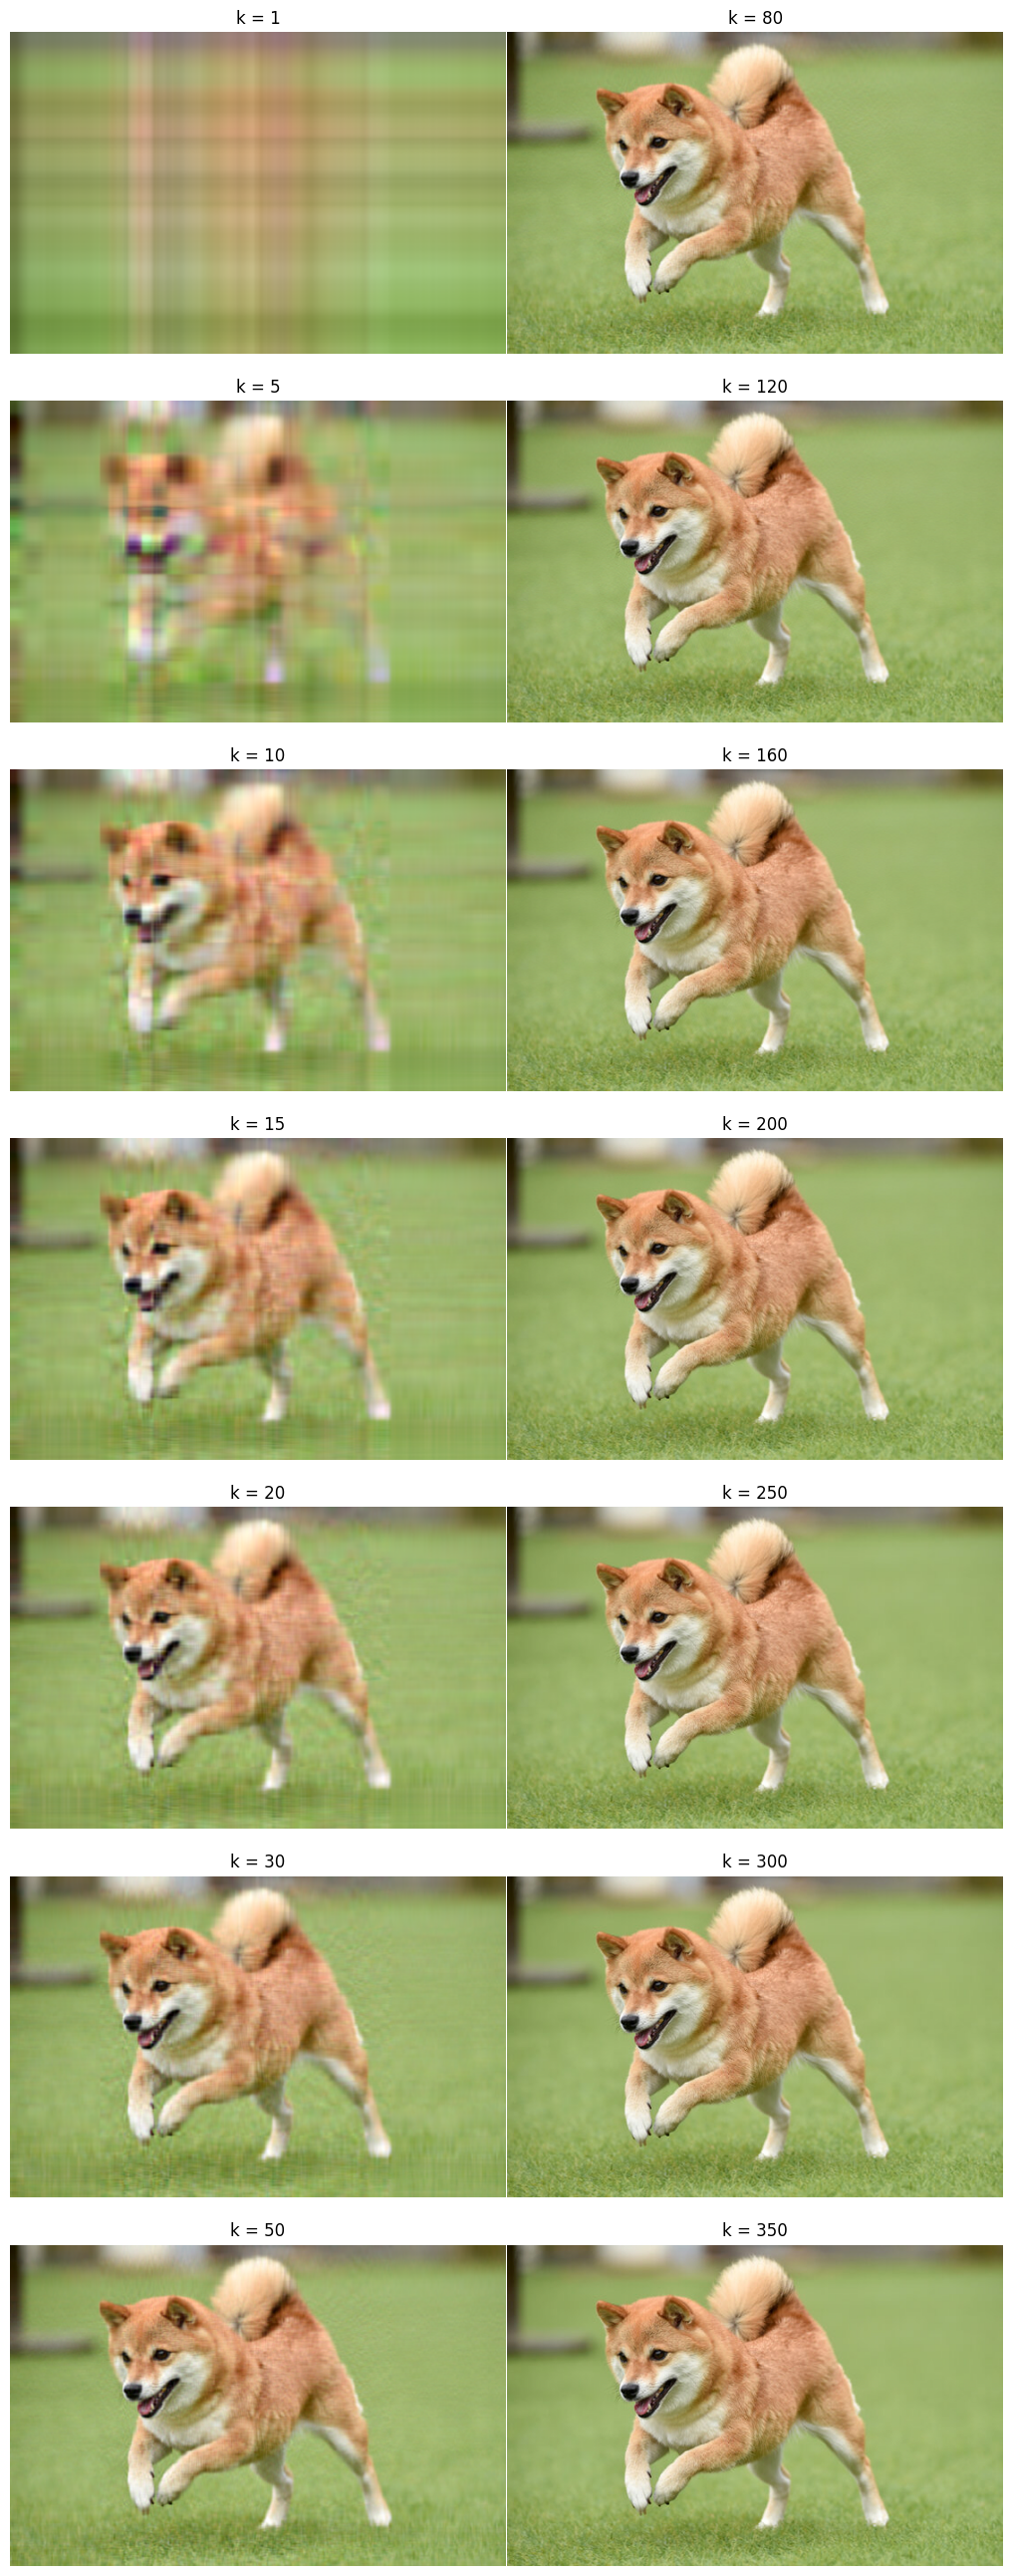

In [38]:
fig, axes = plt.subplots(7, 2, figsize=(10, 26))

img_gen = [] # Clear img_gen before processing RGB images
data = [] # Clear data before processing RGB images

for i in valid_list_k:
  R, sigma_R, norm_R, sigmak1_R, m_R = gen_svd_pic(arr_shiba[:,:,0],i,"R")
  G, sigma_G, norm_G, sigmak1_G, m_G = gen_svd_pic(arr_shiba[:,:,1],i,"G")
  B, sigma_B, norm_B, sigmak1_B, m_B = gen_svd_pic(arr_shiba[:,:,2],i,"B")

  img_rgb_svd = np.dstack((R, G, B))
  img_gen.append(img_rgb_svd)

  # Calculate average norm, sigma_k1, and mse for the RGB image
  avg_norm = (norm_R + norm_G + norm_B) / 3
  avg_sigmak1 = (sigmak1_R + sigmak1_G + sigmak1_B) / 3
  avg_m = (m_R + m_G + m_B) / 3

  data.append([i, avg_norm, avg_sigmak1, compression_rate(arr_shiba, img_rgb_svd, i),
        avg_m, psnr(arr_shiba, img_rgb_svd)])

for i, ax in enumerate(axes.flat):
  if i < len(img_gen):
    row = i % 7       # from row 1 to 7
    col = i // 7      # from column 0 to 1
    ax = axes[row, col]
    ax.imshow(img_gen[i])
    ax.set_title(f'k = {valid_list_k[i]}')
    ax.axis('off')  # 隱藏座標軸
  else:
    fig.delaxes(ax) # Remove unused subplots
plt.tight_layout(pad=0.1)
plt.show()

In [39]:
table = pd.DataFrame(data, columns=list_feature)
table

K       2-norm    sigma k+1          CR         MSE        PSNR
0     1  5748.211478  5748.211478  218.276990  708.931819   19.624382
1     5  2823.730234  2823.730234   43.655398  279.143401   23.672363
2    10  1606.543097  1606.543097   21.827699  144.265316   26.541010
3    15  1179.327366  1179.327366   14.551799   92.026262   28.493004
4    20   868.364397   868.364397   10.913850   64.374247   30.040537
5    30   566.839002   566.839002    7.275900   38.834692   32.234487
6    50   338.306631   338.306631    4.365540   18.899839   35.352610
7    80   206.291423   206.291423    2.728462    8.152491   38.974334
8   120   121.066845   121.066845    1.818975    2.900098   43.385791
9   160    74.342247    74.342247    1.364231    0.974393   47.899296
10  200    42.851746    42.851746    1.091385    0.284013   52.757827
11  250    18.230039    18.230039    0.873108    0.047262   63.041579
12  300     7.779032     7.779032    0.727590    0.008684   80.072477
13  350     3.413490     3.413490    0.623649    0.000445  100.000000

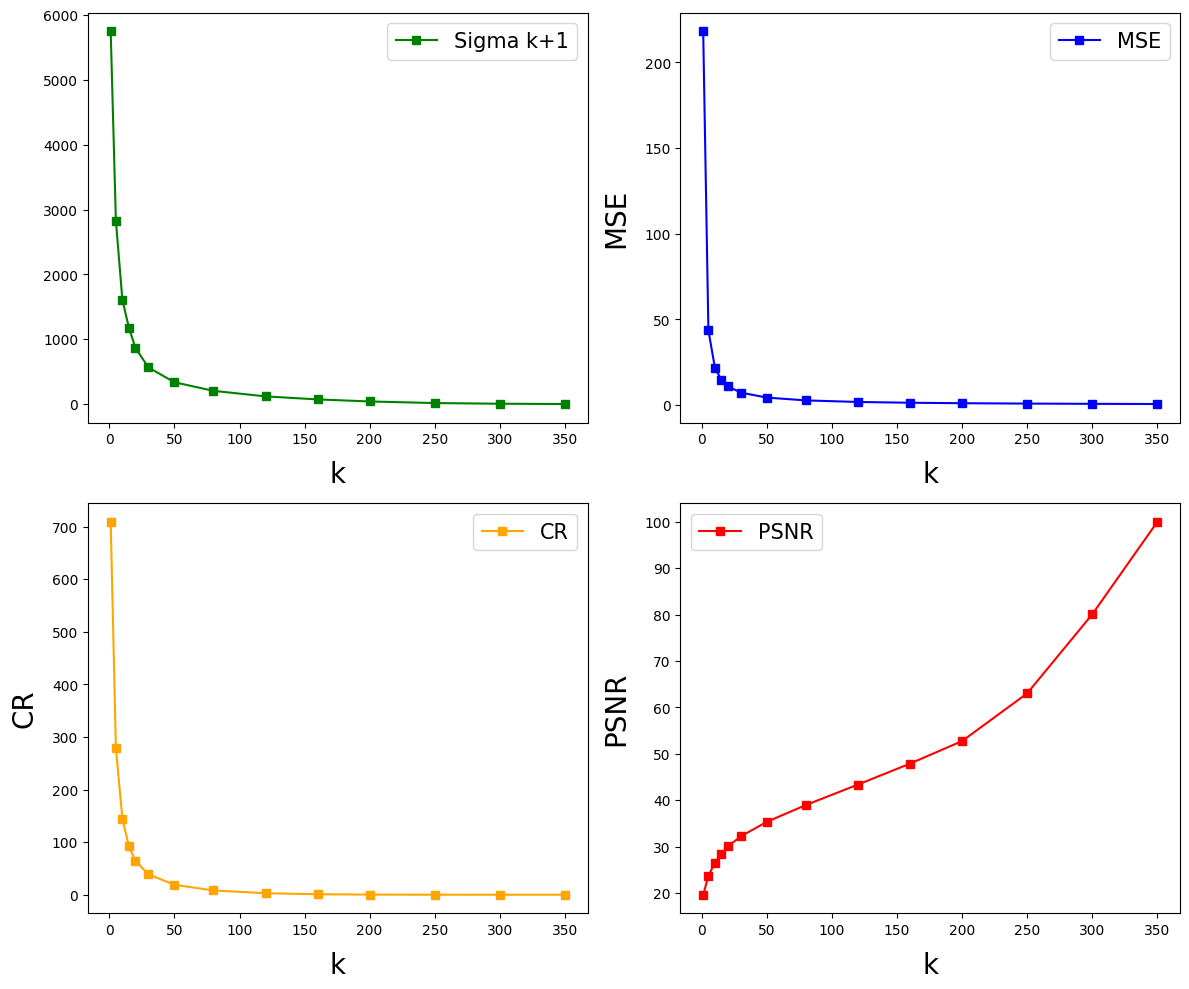

In [40]:
showLinear(table.values, 30)